In [1]:
import sys
sys.path.append("../../")

from astronn.preprocess import predeltascuti, precorot
from astronn.datasets import deltascuti, starmodels, corot
from astronn import models

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import shap

import matplotlib.pyplot as plt
from pygam import LinearGAM
from collections import Counter

Using TensorFlow backend.


#### Load theoretical star models

In [2]:
# Read star models (trainning) to calculate shap values
star_models = starmodels()
df_sm = star_models.load("/home/roberto/Downloads/dataall_parts/*", batch_size=256)

In [3]:
for star in df_sm.take(1):
    print(star)

(<tf.Tensor: shape=(256, 406, 3), dtype=float32, numpy=
array([[[ 0.000e+00,  0.000e+00,  1.000e+00],
        [ 0.000e+00,  0.000e+00,  9.901e-01],
        [ 0.000e+00,  0.000e+00,  9.148e-01],
        ...,
        [ 0.000e+00,  0.000e+00, -6.970e-02],
        [ 0.000e+00,  0.000e+00, -5.800e-02],
        [ 0.000e+00,  0.000e+00,  9.880e-02]],

       [[ 0.000e+00,  0.000e+00,  1.000e+00],
        [ 0.000e+00,  0.000e+00,  9.904e-01],
        [ 0.000e+00,  1.000e+00,  9.174e-01],
        ...,
        [ 0.000e+00,  0.000e+00,  1.400e-02],
        [ 0.000e+00,  0.000e+00,  1.370e-02],
        [ 0.000e+00,  0.000e+00,  2.260e-01]],

       [[ 0.000e+00,  0.000e+00,  1.000e+00],
        [ 0.000e+00,  0.000e+00,  9.903e-01],
        [ 0.000e+00,  0.000e+00,  9.165e-01],
        ...,
        [ 0.000e+00,  0.000e+00,  1.401e-01],
        [ 0.000e+00,  0.000e+00,  1.547e-01],
        [ 0.000e+00,  0.000e+00,  1.588e-01]],

       ...,

       [[ 0.000e+00,  0.000e+00,  1.000e+00],
        [ 0.

In [4]:

"""
## Build the encoder
"""

latent_dim = 2

encoder_inputs = keras.Input(shape=(406, 3))
x = layers.SeparableConv1D(16, 3, activation="relu",  strides=2, padding="same")(encoder_inputs)
x = layers.SeparableConv1D(32, 3, activation="relu",  strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

"""
## Build the decoder
"""

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(102 * 16, activation="relu")(latent_inputs)
x = layers.Reshape((102, 16))(x)
x = layers.SeparableConv1D(16, 3, activation="relu", strides=2, padding="same")(x)
x = layers.SeparableConv1D(32, 3, activation="relu",   strides=2, padding="same")(x)
decoder_outputs = layers.SeparableConv1D(1, 3, activation="sigmoid",  padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

"""
## Define the VAE as a `Model` with a custom `train_step`
"""



"""
## Train the VAE
"""

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01))

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 406, 3)]     0                                            
__________________________________________________________________________________________________
separable_conv1d (SeparableConv (None, 203, 16)      73          input_1[0][0]                    
__________________________________________________________________________________________________
separable_conv1d_1 (SeparableCo (None, 102, 32)      592         separable_conv1d[0][0]           
__________________________________________________________________________________________________
flatten (Flatten)               (None, 3264)         0           separable_conv1d_1[0][0]         
____________________________________________________________________________________________

NameError: name 'latent_inputs' is not defined

In [5]:
vae.fit(df_sm, epochs=5, steps_per_epoch=100)

NameError: name 'vae' is not defined

In [6]:
examples = df_sm.take(10)

labels = []
for example in examples:
    for e in example[1]:
        labels.append(np.where(e[0].numpy().flat == 1)[0].flat[0])
labels = np.asarray(labels)

IndexError: index 0 is out of bounds for axis 0 with size 0

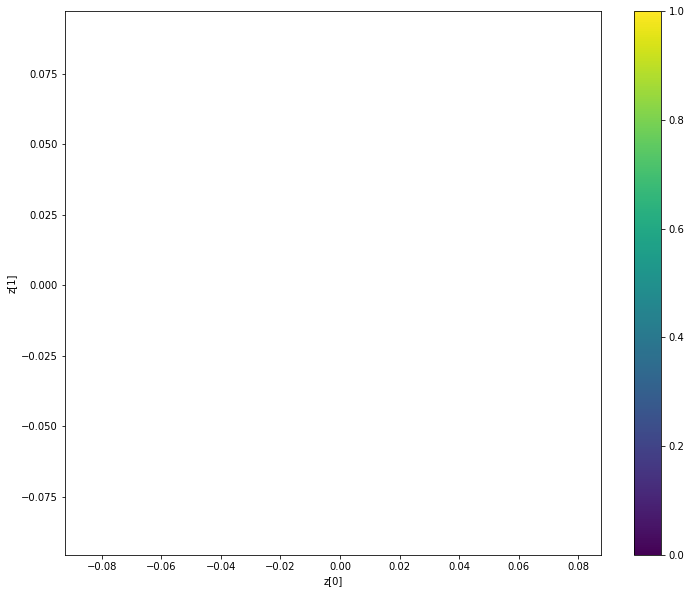

In [7]:
z_mean, _, _ = encoder.predict(examples)
plt.figure(figsize=(12, 10))
plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.show()